# Efficient CNN models for beer bottle cap classification problem
---
In this work, we present an efficient solution to the beer bottle cap classification problem. This problem arises in the Wecheer smart
opener project. Although classification problem is common in Computer
Vision, there is no dedicated work for beer bottle cap dataset. We combine state-of-the-art deep learning techniques to solve the problem. Our
solution outperforms the well-known commercial system that is currently
used by the Wecheer project. It is also more efficient than the famous
architectures such as VGG, ResNet, and DenseNet for our purposes.

Paper: [Efficient CNN models for beer bottle cap classification problem - FDSE2019 Springer LNCS11814](https://link.springer.com/chapter/10.1007/978-3-030-35653-8_51)

*This notebook implemented model of this paper by Keras with Tensorflow backend*

## Skipped VGG model

The architecture take the advantage of *skipped connection* and *VGG* model. Below is the architecture which was applied for beer bottle cap classification in the paper. In particular, we use three blocks and two convolutional layers for each one. In fact, the overall SkippedVGG architecture can have more than 3 blocks with any specific number of convolutional layers and filters, etc.    

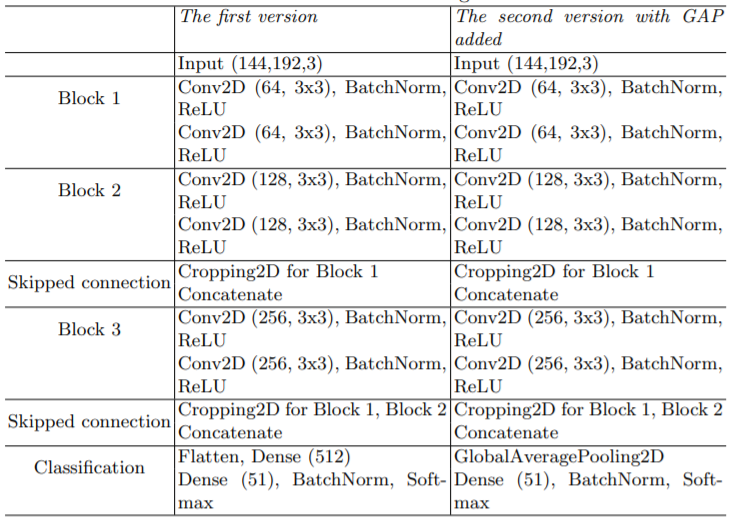

Below we define the function that can generate SkippedVGG style model with specific number of blocks, convolutional layers and filters, loss and optimizer.

In [61]:
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Cropping2D, Dense,concatenate, Input
from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

def SkippedVGG(nb_blocks, input_shape, num_classes, nb_layers, nb_neurons, 
               loss=categorical_crossentropy, optimizer=Adam, learning_rate=0.001, include_top=True, verbose=1):
    '''
    Build SkippedVGG model
    ------------------------
    nb_blocks: int, number of blocks, each block is create by 'define_block' function
    input_shape: tuple, shape of input image excluding batch size. For example: input_shape=(256,256,3)
    nb_layers: int or list, number of convolutional layers for each block. 
                If nb_layers is integer, all blocks has the same number of layers given by nb_layers
    num_classes: int, number of output classes
    nb_neurons: int or list, number of filters for each convolutional layer of earch block.
                If nb_neurons is integer, all convolutional layers in each block has the same number of filters given by nb_neurons
    loss: (callable) keras loss function/instance
    optimizer: (callable) keras optimizer function/instance
    learning_rate: float, learning rate of Adam optimizer
    include_top: boolean. If true, top model (ANN) is stacked
    -------------------------
    Reutrn Keras model instance
    '''
    concats = []
    for i in range(nb_blocks):
        concats.append([])
        
    if type(nb_layers) is int:
        temp = nb_layers
        nb_layers = []
        for i in range(nb_blocks):
            nb_layers.append(temp)
            
    if type(nb_neurons) is int:
        temp_neurons = nb_neurons
        nb_neurons = []
        for i in range(nb_blocks):
            nb_neurons.append(temp_neurons)
    
    if verbose:
        print('Create DensedVGG model with ' + str(nb_blocks) + ' blocks, input shape = ' + str(input_shape))
    
    for i in range(nb_blocks):
        if verbose:
            print('Create block ' + str(i) + ':')
        
        if i == 0: # First block
            b = Input(shape=input_shape)
            inputs = b
        
        # check all layers before
        if len(concats[i-1]) > 1:
            if verbose:
                print('Concatenate ', concats[i-1])
            b = concatenate(concats[i-1])
        elif len(concats[i-1]) == 1:
            if verbose:
                print('Get direct output from the previous block ', concats[i-1])
            b = concats[i-1][0]
            
        # create main block
        b = define_block(b, nb_layers[i], nb_neurons[i], index=i)
        concats[i].append(b)
        
        # create cropping layer
        for j in range(i+1, nb_blocks):
            if verbose:
                print('-- create skipped connection from block '+ str(i) + ' to block ' + str(j+1) + ' ...')
                
            src_shape = b.get_shape()
            src_shape = (int(src_shape[1]), int(src_shape[2]), int(src_shape[3]))
            dst_shape = (src_shape[0]//2**(j-i), src_shape[1]//2**(j-i), src_shape[2])
            
            print(src_shape, dst_shape)
            h = src_shape[0] - dst_shape[0]
            w = src_shape[1] - dst_shape[1]
            if h % 2 == 0:
                h_0 = h // 2
                h_1 = h // 2
            else:
                h_0 = h // 2
                h_1 = (h // 2) + 1
            
            if w % 2 == 0:
                w_0 = w // 2
                w_1 = w // 2
            else:
                w_0 = w // 2
                w_1 = (w // 2) + 1
                
            concat_layer = Cropping2D(((h_0,h_1),(w_0,w_1)), name='cropping_block' + str(i) + '_block' + str(j+1))(b)
            concats[j].append(concat_layer)
            
    # top model
    if verbose:
        print('Create top model')
    if nb_blocks == 1:
        outputs = concats[0][0]
    elif len(concats[nb_blocks-1]) == 1:
        outputs = concats[nb_blocks-1]
    else:
        outputs = concatenate(concats[nb_blocks-1])
    
    outputs = GlobalAveragePooling2D()(outputs)
    outputs = Dense(num_classes)(outputs)
    outputs = BatchNormalization()(outputs)
    outputs = Activation('softmax')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    
    # compile
    model.compile(loss=loss, optimizer=optimizer(learning_rate), metrics=['accuracy'])
    
    if verbose:
        model.summary()
    return model

def define_block(input_layer, nb_layers, nb_neurons, kernel_size=(3,3), batch_normalization=True, activation='relu', **kwargs):
    '''
    Define a block in SkippedVGG
    ------------------------
    input_layer: Keras layer instance, input of this layer
    nb_layers: list, number of convolutional layers
    nb_neurons: int, number of filters in conv layers
    kernel_size: int or tuple
    batch_normalization: boolean. If True, batch normalization layer is used
    activation: str, kind of activation layer, the default valus is ReLU
    index (optional): int, index of this block
    -------------------------
    Return Keras layer instance
    '''
    index = None
    if 'index' in kwargs:
        index = kwargs['index']
    
    for i in range(nb_layers):
        if i == 0:
            b = input_layer
            
        b = Conv2D(nb_neurons, kernel_size=kernel_size, strides=1, padding='same', name='conv' + str(i) + '_block' + str(index))(b)
        if batch_normalization:
            b = BatchNormalization(name='batchnorm' + str(i) + '_block' + str(index))(b)
        b =  Activation(activation, name=activation + str(i) + '_block' + str(index))(b)
    b = MaxPooling2D(pool_size=(2,2), name='maxpooling_block' + str(index))(b)
    return b

## SkippedVGG training on CIFAR-10 demo

In [2]:
# Set up GPU
import os
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"]="0"
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
print (session.run(c))

[[22. 28.]
 [49. 64.]]


In [19]:
# load the dataset
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

170500096/170498071 [==============================] - 178s 1us/step


((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

Training data should be split into training data and validation data

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((35000, 32, 32, 3), (15000, 32, 32, 3), (35000, 1), (15000, 1))

The labels of dataset is currently single number layer, we need to convert them into onehot encoding labels using built-in function of keras

In [5]:
from keras.utils import to_categorical

encoded_y_train = to_categorical(y_train, num_classes=10) # we have 10 classes
encoded_y_val = to_categorical(y_val, num_classes=10)
encoded_y_test = to_categorical(y_test, num_classes=10)

encoded_y_train.shape, encoded_y_val.shape, encoded_y_test.shape

((35000, 10), (15000, 10), (10000, 10))

In [6]:
model = SkippedVGG(nb_blocks=4, input_shape=(32,32,3), num_classes=10, 
                   nb_layers=[2,2,3,3], nb_neurons=[64,128,256,512], learning_rate=0.001, 
                   include_top=True, verbose=1)

Create DensedVGG model with 4 blocks, input shape = (32, 32, 3)
Create block 0:
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

-- create skipped connection from block 0 to block 2 ...
(16, 16, 64) (8, 8, 64)
-- create skipped connection from block 0 to block 3 ...
(16, 16, 64) (4, 4, 64)
-- create skipped connection from block 0 to block 4 ...
(16, 16, 64) (2, 2, 64)
Create block 1:
Get direct output from the previous block  [<tf.Tensor 'maxpooling_block0/MaxPool:0' shape=(?, 16, 16, 64) dtype=float32>]
-- create skipped connection from block 1 to block 3 ...
(8, 8, 128) (4, 4, 128)
-- create skipped connection from block 1 to block 4 ...
(8, 8, 128) (2, 2, 128)
Create block 2:
Concatenate  [<tf.Tensor 'cropping_block0_block2/strided_slice:0' shape=(?, 8, 8, 64) dtype=float32>, <tf.Tensor 'maxpooling_block1/MaxPool:0' shape=(?, 8, 8, 128) dtype=float32>]
-- create skipped connection from block 2 to block 4 ...
(4, 4, 256) (2, 2, 256)
Create block 3:
C

We often apply data augmentation for training to prevent overfitting, this can be archived by Keras built-in generator

In [7]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 128

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=360, fill_mode='nearest') # apply data augmentation by rotation
test_datagen = ImageDataGenerator(rescale=1./255) # for validation and testing, we just need to rescale image

# apply to dataset
train_generator = train_datagen.flow(x_train, encoded_y_train, batch_size=32, shuffle=True)
validation_generator = test_datagen.flow(x_val, encoded_y_val, batch_size=32, shuffle=False)
test_generator = test_datagen.flow(x_test, encoded_y_test, batch_size=1, shuffle=False)

Train model, we keep tracking optimal model that gives best accuracy on validation dataset by using Keras Modelcheckpoint callbacks

In [20]:
from keras.callbacks import ModelCheckpoint

model_path = './optimal_cifar_model.hdf5'
mcp = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False)

training_history = model.fit_generator(train_generator, steps_per_epoch=len(x_train)//batch_size,
                                      epochs=100, validation_data=validation_generator,
                                      validation_steps=len(x_val)//batch_size,
                                      callbacks=[mcp], verbose=1)

Epoch 1/100
273/273 [==============================] - 7s 24ms/step - loss: 1.4577 - accuracy: 0.4852 - val_loss: 1.5910 - val_accuracy: 0.4137
Epoch 2/100
273/273 [==============================] - 7s 24ms/step - loss: 1.4365 - accuracy: 0.4895 - val_loss: 1.2813 - val_accuracy: 0.4813
Epoch 3/100
273/273 [==============================] - 7s 24ms/step - loss: 1.3789 - accuracy: 0.5151 - val_loss: 1.6975 - val_accuracy: 0.4685
Epoch 4/100
273/273 [==============================] - 6s 24ms/step - loss: 1.3778 - accuracy: 0.5177 - val_loss: 1.4661 - val_accuracy: 0.4826
Epoch 5/100
273/273 [==============================] - 7s 24ms/step - loss: 1.3358 - accuracy: 0.5354 - val_loss: 1.6415 - val_accuracy: 0.3986
Epoch 6/100
273/273 [==============================] - 6s 23ms/step - loss: 1.3079 - accuracy: 0.5353 - val_loss: 1.8486 - val_accuracy: 0.4038
Epoch 7/100
273/273 [==============================] - 6s 24ms/step - loss: 1.2831 - accuracy: 0.5486 - val_loss: 1.5758 - val_accuracy:

273/273 [==============================] - 6s 24ms/step - loss: 0.7405 - accuracy: 0.7423 - val_loss: 1.2163 - val_accuracy: 0.6092
Epoch 58/100
273/273 [==============================] - 6s 24ms/step - loss: 0.7571 - accuracy: 0.7394 - val_loss: 1.4013 - val_accuracy: 0.6277
Epoch 59/100
273/273 [==============================] - 6s 24ms/step - loss: 0.7409 - accuracy: 0.7478 - val_loss: 0.9635 - val_accuracy: 0.6709
Epoch 60/100
273/273 [==============================] - 6s 24ms/step - loss: 0.7368 - accuracy: 0.7388 - val_loss: 1.0993 - val_accuracy: 0.6960
Epoch 61/100
273/273 [==============================] - 6s 24ms/step - loss: 0.7295 - accuracy: 0.7500 - val_loss: 0.8529 - val_accuracy: 0.7024
Epoch 62/100
273/273 [==============================] - 7s 24ms/step - loss: 0.7175 - accuracy: 0.7550 - val_loss: 0.7260 - val_accuracy: 0.7361
Epoch 63/100
273/273 [==============================] - 7s 24ms/step - loss: 0.7094 - accuracy: 0.7552 - val_loss: 0.6819 - val_accuracy: 0.723

Plot training result

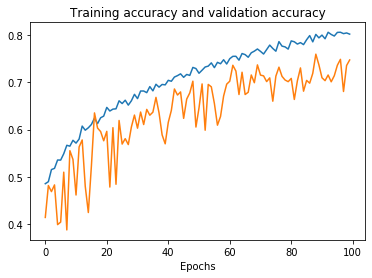

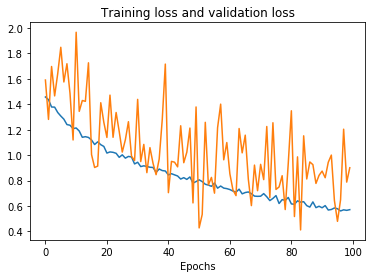

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(training_history.history['accuracy'], label='accuarcy')
plt.plot(training_history.history['val_accuracy'], label='validation accuarcy')
plt.title('Training accuracy and validation accuracy')
plt.xlabel('Epochs')
plt.show()

plt.plot(training_history.history['loss'], label='loss')
plt.plot(training_history.history['val_loss'], label='validation loss')
plt.title('Training loss and validation loss')
plt.xlabel('Epochs')
plt.show()


Evaluate on test data

In [8]:
from keras.models import load_model

# load optimal model
optimal_model = load_model('./optimal_cifar_model.hdf5')

# evaluate
score = optimal_model.evaluate_generator(test_generator, steps=len(x_test), verbose=1)
print('Test loss: {0} \t Test accuracy: {1}'.format(score[0], score[1]))


10000/10000 [==============================] - 77s 8ms/step
Test loss: 0.004358198493719101 	 Test accuracy: 0.7386999726295471


## Class activation map visualization

For better understanding about the region where our model focused, we apply [Class Activation Map]() to produce heat map which is able to visualize the intensity of model's decision on the input image. Generally to archive this approach, the model should have global average pooling layer.

In [87]:
import keras.backend as K
import numpy as np
import cv2
from skimage.transform import resize

def visualize_cam(model, image, last_conv_layer_index, learning_phase=0, path_to_save=None):
    '''
  visualize class activation map function
  ----------------------------------------
  arguments:
  - model: Keras model instance with average pooling layer
  - image: image to apply cam
  - last_conv_layer_index: index of last convolution layer
  - learning_phase: integer, if 1 then mode='learing', else if 0 then mode='testing'
  - path_to_save: path to save the image
  -----------------------------------------
  return:
    predictions: softmax vector
  '''

    '''Get weights of dense output layer'''
    class_weights = model.layers[-3].get_weights()[0]

    '''Create the function to get last conv layer output and model output'''
    last_conv_layer = model.layers[last_conv_layer_index].output
    get_output = K.function([model.input, K.learning_phase()], [last_conv_layer, model.output])

#     img = np.array([np.transpose(np.float32(image), (0, 1, 2))])
    img = np.asarray(image, dtype='float')
    if np.max(img) > 1:
        img /= 255.
        
    img = np.expand_dims(img, axis=0)

    [conv_outputs, predictions] = get_output([img, learning_phase])
    conv_outputs = conv_outputs[0,:,:,:]

    '''Create the class activation map'''
    class_num = np.argmax(predictions, axis=1)[0]
    prob = np.max(predictions, axis=1)[0]
    cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[:2])

    for i,w in enumerate(class_weights[:,class_num]):
        cam += w*conv_outputs[:,:,i]
    cam /= np.max(cam)
    cam = resize(cam, (image.shape[0], image.shape[1]))
    
    plt.imshow(cam, cmap='jet', alpha=0.6)
    plt.imshow(image, alpha=0.4)
        
    
    if path_to_save is not None:
        plt.savefig(path_to_save)
        
    return class_num, prob

In [82]:
cifar10_labels = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck']

In [ ]:
# load optimal model
optimal_model = load_model('./optimal_cifar_model.hdf5')

Prediction: ship | 0.6762506365776062


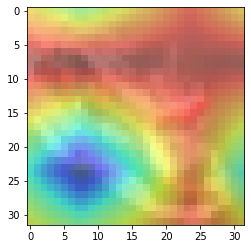

In [84]:
from keras.models import load_model
from skimage.transform import resize

# apply CAM
class_num, prob = visualize_cam(optimal_model, x_test[15], last_conv_layer_index=-5, learning_phase=0)

print('Prediction: {0} | {1}'.format(cifar10_labels[class_num], prob))

Prediction: dog | 0.5459744930267334


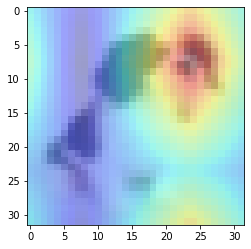

In [90]:
# apply CAM
class_num, prob = visualize_cam(optimal_model, x_test[212], last_conv_layer_index=-5, learning_phase=0)

print('Prediction: {0} | {1}'.format(cifar10_labels[class_num], prob))

Prediction: horse | 0.9956513047218323


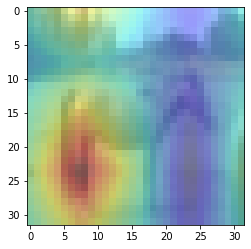

In [89]:
# apply CAM
class_num, prob = visualize_cam(optimal_model, x_test[-1], last_conv_layer_index=-5, learning_phase=0)

print('Prediction: {0} | {1}'.format(cifar10_labels[class_num], prob))